# Building A Linear Regression with PySpark and MLlib

In this post, I’ll help you get started using Apache Spark’s spark.ml Linear Regression for predicting Boston housing prices. Our data is from the Kaggle competition: Housing Values in Suburbs of Boston. For each house observation, we have the following information:

CRIM — per capita crime rate by town.

ZN — proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS — proportion of non-retail business acres per town.

CHAS — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

NOX — nitrogen oxides concentration (parts per 10 million).

RM — average number of rooms per dwelling.

AGE — proportion of owner-occupied units built prior to 1940.

DIS — weighted mean of distances to five Boston employment centres.

RAD — index of accessibility to radial highways.

TAX — full-value property-tax rate per $10,000.

PTRATIO — pupil-teacher ratio by town.

BLACK — 1000(Bk — 0.63)² where Bk is the proportion of blacks by town.

LSTAT — lower status of the population (percent).

MV — median value of owner-occupied homes in $1000s. This is the target variable.

The input data set contains data about details of various houses. Based on the information provided, the goal is to come up with a model to predict median value of a given house in the area.

### Import the necessary Packages:

In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [12]:
spark = SparkSession.builder.appName("BostonHousing").getOrCreate()


### Data exploration

Print Schema in a tree format.

In [51]:
house_df = spark.read.csv("data/Boston_Housing.csv", inferSchema=True, header =True)
house_df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MEDV: double (nullable = true)



In [10]:
house_df.cache()
house_df.printSchema()

root
 |--  0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00: string (nullable = true)



Perform descriptive analytics

In [16]:
house_df.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
CRIM,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
ZN,506,11.363636363636363,23.32245299451514,0.0,100.0
INDUS,506,11.136778656126504,6.860352940897589,0.46,27.74
CHAS,506,0.0691699604743083,0.2539940413404101,0,1
NOX,506,0.5546950592885372,0.11587767566755584,0.385,0.871
RM,506,6.284634387351787,0.7026171434153232,3.561,8.78
AGE,506,68.57490118577078,28.148861406903595,2.9,100.0
DIS,506,3.795042687747034,2.10571012662761,1.1296,12.1265
RAD,506,9.549407114624506,8.707259384239366,1,24


Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables.

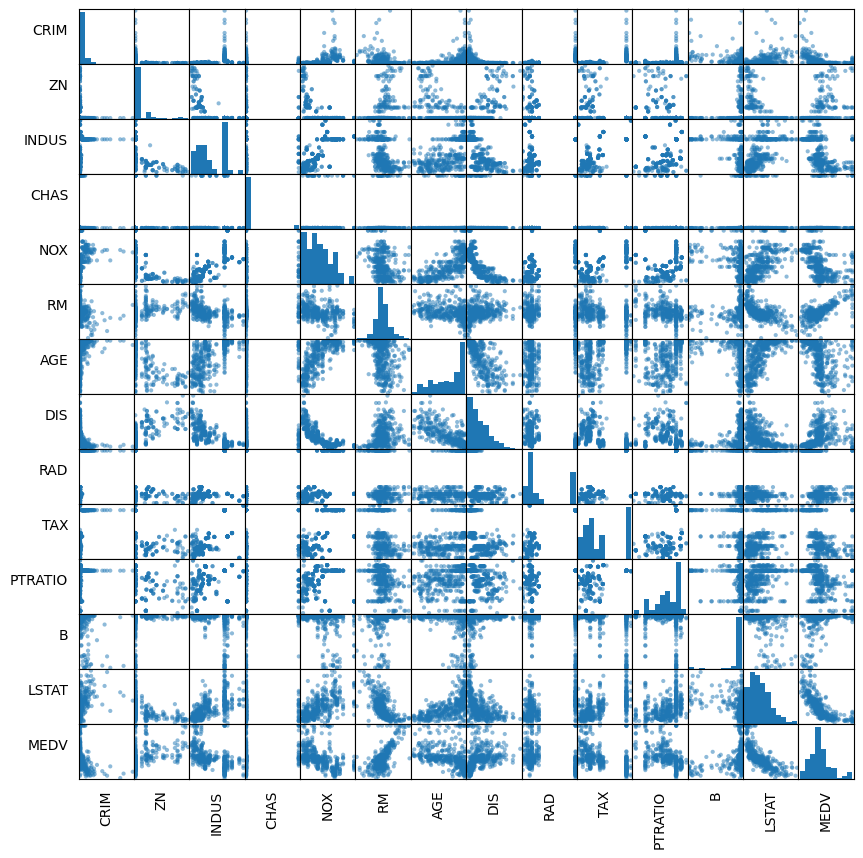

In [21]:
import pandas as pd

numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

It’s hard to see. Let’s find correlation between independent variables and target variable.

In [25]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('MEDV',i))

Correlation to MV for  CRIM -0.38830460858681154
Correlation to MV for  ZN 0.3604453424505433
Correlation to MV for  INDUS -0.4837251600283728
Correlation to MV for  CHAS 0.1752601771902987
Correlation to MV for  NOX -0.4273207723732821
Correlation to MV for  RM 0.6953599470715401
Correlation to MV for  AGE -0.3769545650045961
Correlation to MV for  DIS 0.249928734085904
Correlation to MV for  RAD -0.38162623063977735
Correlation to MV for  TAX -0.46853593356776674
Correlation to MV for  PTRATIO -0.5077866855375622
Correlation to MV for  B 0.3334608196570661
Correlation to MV for  LSTAT -0.7376627261740145
Correlation to MV for  MEDV 1.0


We are going to keep all the variables, for now.

Prepare data for Machine Learning. And we need two columns only — features and label(“MEDV”):

In [28]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'MEDV'])
vhouse_df.show(3)

22/11/28 19:57:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----+
|            features|MEDV|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



In [29]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Linear Regression 

In [32]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MEDV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

22/11/28 19:59:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/28 19:59:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Coefficients: [-0.052913830056115885,0.005271431404646198,-0.03599958373385843,1.6054324161664362,-4.081382523953949,3.6781965681444246,0.0,-0.5775975833144774,0.0007569854112140574,0.0,-0.8285215080859538,0.008270616101182161,-0.5152222087286804]
Intercept: 23.233938882097338


Summarize the model over the training set and print out some metrics:

In [33]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5.123213
r2: 0.682845


RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual "MV" value, such as mean, min and max. After such comparison, our RMSE looks pretty good.

In [34]:
train_df.describe().show()


+-------+-----------------+
|summary|             MEDV|
+-------+-----------------+
|  count|              336|
|   mean|22.35029761904762|
| stddev| 9.11074484073336|
|    min|              5.0|
|    max|             50.0|
+-------+-----------------+



In [37]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MEDV","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MEDV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|MEDV|            features|
+------------------+----+--------------------+
|30.912494558242454|24.0|[0.00632,18.0,2.3...|
|29.628685279594556|35.4|[0.01311,90.0,1.2...|
| 37.42194845624565|50.0|[0.01381,80.0,0.4...|
|30.440423641112954|29.1|[0.01439,60.0,2.9...|
|39.751958007471046|50.0|[0.01501,90.0,1.2...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.758002


In [38]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.60178


## Decision tree regression


In [41]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'MEDV')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="MEDV", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.04354


 Feature Imortance 

In [42]:
train_df.take(1)


[Row(features=DenseVector([0.0091, 90.0, 2.97, 0.0, 0.4, 7.088, 20.8, 7.3073, 1.0, 285.0, 15.3, 394.72, 7.85]), MEDV=32.2)]

In [43]:
dt_model.featureImportances


SparseVector(13, {0: 0.0161, 2: 0.0015, 4: 0.0816, 5: 0.548, 6: 0.0115, 7: 0.0863, 9: 0.0038, 10: 0.0086, 11: 0.0057, 12: 0.2369})

In [44]:
house_df.take(1)

[Row(CRIM=0.00632, ZN=18.0, INDUS=2.31, CHAS=0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1, TAX=296, PTRATIO=15.3, B=396.9, LSTAT=4.98, MEDV=24.0)]

The number of rooms is the most important feature to predict the house price.

## Gradient-boosted tree regression


In [48]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'MEDV', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'MEDV', 'features').show(5)

+-----------------+----+--------------------+
|       prediction|MEDV|            features|
+-----------------+----+--------------------+
|23.90713808229739|24.0|[0.00632,18.0,2.3...|
|34.85150956609258|35.4|[0.01311,90.0,1.2...|
|46.25376624965973|50.0|[0.01381,80.0,0.4...|
|25.30726781974368|29.1|[0.01439,60.0,2.9...|
|47.63891166847676|50.0|[0.01501,90.0,1.2...|
+-----------------+----+--------------------+
only showing top 5 rows



In [49]:
gbt_evaluator = RegressionEvaluator(
    labelCol="MEDV", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.5941
